In [1]:
import sympy as sp
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import warnings
from numba.core.errors import NumbaWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NumbaWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.hessian import hess

Cache analytic expressions to save time

### **Errorbars in parameters**

Laplace approximation for likelihood function around the maximum:

$$ \log P(\bm{\theta} \mid \{\log L_i \}) \approx
\log P'(\bm{\theta}) = \log P'(\bm{\theta}_0) - \frac{1}{2} (\bm{\theta} - \bm{\theta}_0)^\intercal \bm{A} (\bm{\theta} - \bm{\theta}_0)$$
where
$$ A_{ij} = \left . - \frac{\partial^2}{\partial\theta_i \partial\theta_j} \log P(\bm{\theta} \mid \{\log L_i \}) \right\vert_{\bm{\theta} = \bm{\theta}_0} = -H_{ij}$$

#### **Evidence for model**

$$ \log Z = \log L_\mathrm{max} + \frac{1}{2} \log |2\pi\Sigma| - \log V_\pi $$
$$ \log Z = \log P'(\bm{\theta}_0)  + \frac{1}{2} \log |2\pi H^{-1}| - \log V_\pi $$
$$ Z = P'(\bm{\theta}_0) \sqrt{\frac{2\pi |H^{-1}|}{V_\pi}} $$


Find Hessian numerically using `autograd`, compare to analytical expression for simple cases

If 1D $\theta$, then 1D Gaussian, $A$ is a constant. Check with meshgrid in 2D.

### **Verify Hessian obtained is a good approximation near the maximum**

In [4]:
nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 0.1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
logLmax0, d0, sigma0 = theta_max
print(f'{theta_max}')
print(f'pr(theta_true): {logPr_bayes(y, full, mean_X, covinv_X, theta_true)}')
print(f'pr(theta_b): {logPr_bayes(y, full, mean_X, covinv_X, theta_max)}')

[1.02645185 9.89665391 0.09995564]
pr(theta_true): -1593.1303552297024
pr(theta_b): -1592.6745887022325


In [5]:
H = hess(y, mean_X, covinv_X, theta_max)
cov_theta = np.linalg.inv(-H)

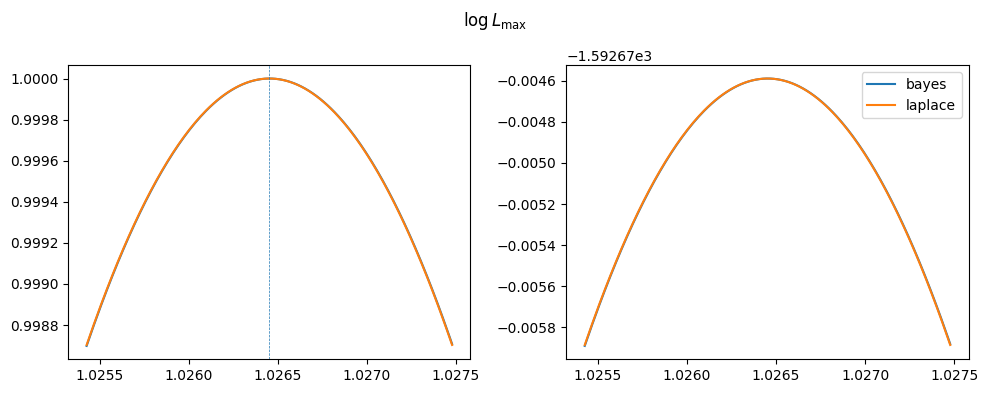

In [6]:
logLmaxs = np.linspace(logLmax0*0.999, logLmax0*1.001, 200)
prs_bayes = np.zeros_like(logLmaxs)
prs_laplace = np.zeros_like(logLmaxs)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, logLmax_ in enumerate(logLmaxs):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax_, d0, sigma0])
    prs_laplace[i] = logPr_laplace(logLmax_, logprmax, logLmax0, H[0][0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(logLmaxs, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
ax1.plot(logLmaxs, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
ax1.axvline(x=logLmax0, ls='--', lw=.5)
ax2.plot(logLmaxs, prs_bayes, label='bayes')
ax2.plot(logLmaxs, prs_laplace, label='laplace')
plt.suptitle('$\log{L_\mathrm{max}}$', y=0.97)
plt.legend();
plt.tight_layout()

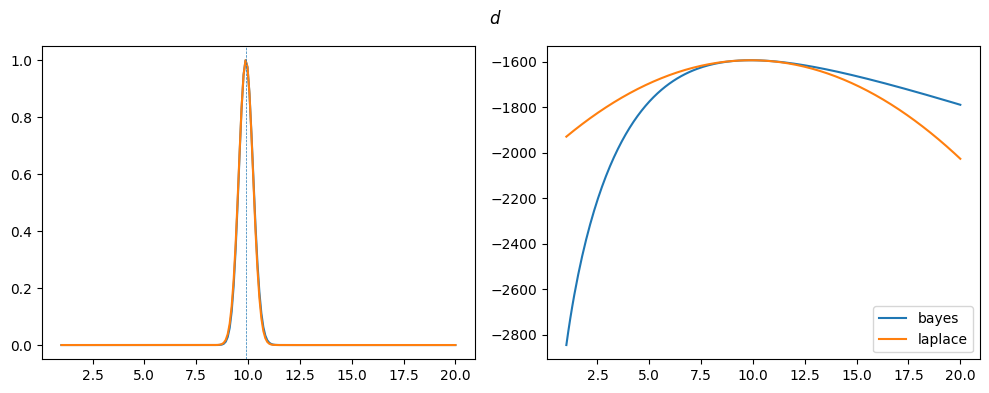

In [10]:
ds = np.linspace(1, 20, 200)
prs_bayes = np.zeros_like(ds)
prs_laplace = np.zeros_like(ds)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, d_ in enumerate(ds):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax0, d_, sigma0])
    prs_laplace[i] = logPr_laplace(d_, logprmax, d0, H[1][1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(ds, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
ax1.plot(ds, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
ax1.axvline(x=d0, ls='--', lw=.5)
ax2.plot(ds, prs_bayes, label='bayes')
ax2.plot(ds, prs_laplace, label='laplace')
plt.suptitle('$d$', y=0.97)
plt.legend();
plt.tight_layout()

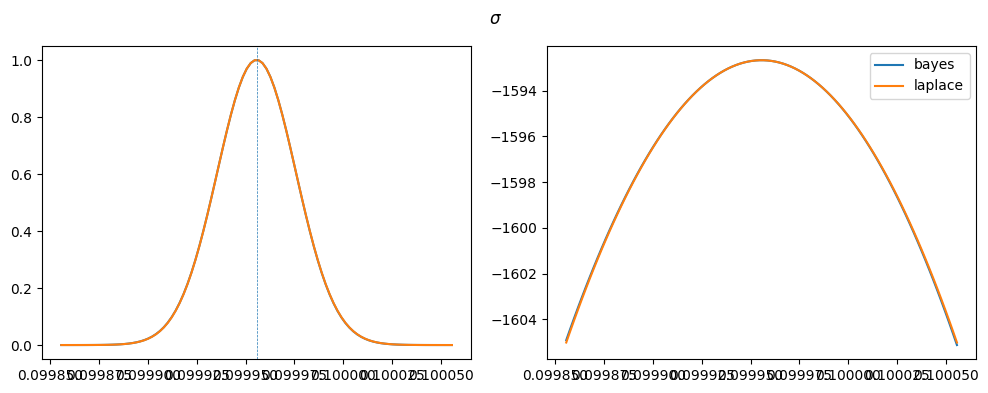

In [12]:
sigmas = np.linspace(sigma0*0.999, sigma0*1.001, 100)
prs_bayes = np.zeros_like(sigmas)
prs_laplace = np.zeros_like(sigmas)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, sigma_ in enumerate(sigmas):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax0, d0, sigma_])
    prs_laplace[i] = logPr_laplace(sigma_, logprmax, sigma0, H[2][2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(sigmas, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
ax1.plot(sigmas, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
ax1.axvline(x=sigma0, ls='--', lw=.5)
ax2.plot(sigmas, prs_bayes, label='bayes')
ax2.plot(sigmas, prs_laplace, label='laplace')
plt.suptitle('$\sigma$', y=0.97)
plt.legend();
plt.tight_layout()

### **Analytic errorbars**

In [15]:
nk = 500 * np.ones(2000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
logLmax0, d0, sigma0 = theta_max
print(f'{theta_max}')
pr_thetamax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)
print(f'pr(theta_true): {logPr_bayes(y, full, mean_X, covinv_X, theta_true)}')
print(f'pr(theta_b): {pr_thetamax}')

[0.99710642 9.69034028 1.00299316]
pr(theta_true): 343.7013006069228
pr(theta_b): 347.161862209452


In [6]:
H = hess(y, mean_X, covinv_X, theta_max)
cov_theta = np.linalg.inv(-H)

array([[-2.52321290e+07,  7.58572687e+03, -2.36873418e+07],
       [ 7.58572687e+03, -1.23367633e+02,  2.32375849e+03],
       [-2.36873418e+07,  2.32375849e+03, -2.22875509e+07]])

/tmp/ipykernel_5647/1697681734.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  theta = np.random.multivariate_normal(theta_max, cov_theta)


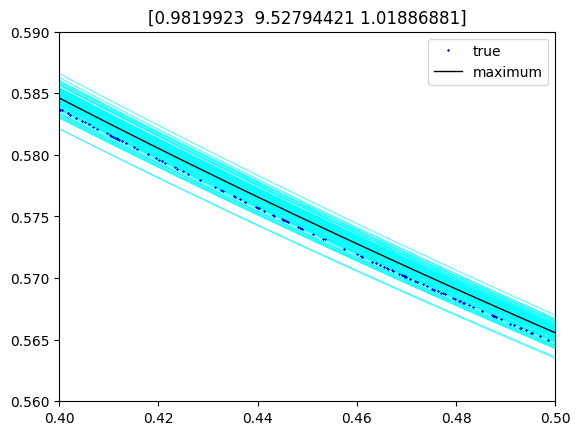

In [9]:
for i in range(100):
    theta = np.random.multivariate_normal(theta_max, cov_theta)
    X_b = full.inverse(y, theta)
    plt.plot(X_b, y, lw=.5, color='cyan')
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(full.inverse(y, theta_max), y, lw=1, color='black', label='maximum')
plt.title(theta_max)
plt.xlim(0.4, 0.5)
plt.ylim(0.56, 0.59)
plt.legend();

/tmp/ipykernel_5647/3160451984.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  theta = np.random.multivariate_normal(theta_max, cov_theta)


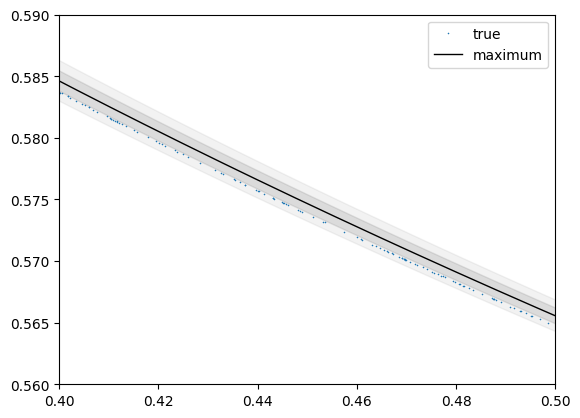

In [11]:
samples = 1000
Xarrays = np.zeros((samples, len(y)))
for i in range(samples):
    theta = np.random.multivariate_normal(theta_max, cov_theta)
    X_b = full.inverse(y, theta)
    Xarrays[i] = X_b
X_std = Xarrays.T.std(axis=1)
X_mean = Xarrays.T.mean(axis=1)

X_b = full.inverse(y, theta_max)
plt.plot(X, y, 'x', ms=.5, label='true')
plt.plot(X_b, y, lw=1, color='black', label='maximum')
# plt.plot(X_mean, y, lw=1, color='yellow', label='mean')
plt.fill_betweenx(y, X_b - 2*X_std, X_b + 2*X_std, color='gray', alpha=0.1)
plt.fill_betweenx(y, X_b - X_std, X_b + X_std, color='gray', alpha=0.2)
plt.xlim(0.4, 0.5)
plt.ylim(0.56, 0.59)
plt.legend();

### **Check analytic Hessian**

In [39]:
import numpy as np
import sympy as sp
import numba as nb

logLmax, d, sigma = sp.symbols('\log{L_\mathrm{max}} d \sigma')
X_i, logL_i, logL_j = sp.symbols('X_i \log{L_i} \log{L_j}')
mu_i, mu_j = sp.symbols('\mu_i, \mu_j')


def f(X_i, logLmax, d, sigma):
    return logLmax - X_i**(2/d)/(2*sigma**2)

def fprime(X_i, logLmax, d, sigma):
    return sp.diff(f(X_i, logLmax, d, sigma), X_i)

def abs_fprime(X_i, logLmax, d, sigma):
    return - fprime(X_i, logLmax, d, sigma)

def X_logLi(logL_i, logLmax, d, sigma):
    return (2*sigma**2 * (logLmax - logL_i))**(d/2)

def log_abs_fprime_Xstar(logL_i, logLmax, d, sigma):
    Xstar_i = X_logLi(logL_i, logLmax, d, sigma)
    return sp.log(abs_fprime(X_i, logLmax, d, sigma).subs(X_i, Xstar_i))

def cross_terms(logL_i, logL_j, logLmax, d, sigma):
    Xstar_i = X_logLi(logL_i, logLmax, d, sigma)
    Xstar_j = X_logLi(logL_j, logLmax, d, sigma)
    return (Xstar_i - mu_i) * (Xstar_j - mu_j)

def hess_fprime_i(theta_1, theta_2):
    symbolic_expr = sp.diff(log_abs_fprime_Xstar(logL_i, logLmax, d, sigma), theta_1, theta_2)
    symbolic_expr = sp.simplify(symbolic_expr)
    numeric_func = sp.lambdify([logL_i, logLmax, d, sigma], symbolic_expr)
    return numeric_func

def hess_cross_ij(theta_1, theta_2):
    symbolic_expr = sp.simplify(sp.diff(cross_terms(logL_i, logL_j, logLmax, d, sigma), theta_1, theta_2))
    numeric_func = sp.lambdify([logL_i, logL_j, mu_i, mu_j, logLmax, d, sigma], symbolic_expr)
    return numeric_func

def hess_logfprime(logL, theta_max, theta_1, theta_2):
    if set([theta_1, theta_2]) == set([logLmax, sigma]):
        return 0
    hess_fprime_i_array = hess_fprime_i(theta_1, theta_2)(logL, *theta_max) * np.ones_like(logL) # ensures still array-like if independent of logL_i
    return hess_fprime_i_array.sum()

def hess_cross(logL, mean, covinv, theta_max, theta_1, theta_2):
    hess_tt_ij = hess_cross_ij(theta_1, theta_2)
    k = len(logL)
    @nb.jit
    def quad():
        quad = 0
        for i in range(k):
            cross_i = hess_tt_ij(logL[i], logL, mean[i], mean, *theta_max) * covinv[i]
            quad += cross_i.sum()
        return quad
    return quad()

def hess_tt(logL, mean, covinv, theta_max, theta_1, theta_2):
    return - hess_logfprime(logL, theta_max, theta_1, theta_2) - 1/2 * hess_cross(logL, mean, covinv, theta_max, theta_1, theta_2)

def hess(logL, mean, covinv, theta_max):
    dim = 3
    hess = np.zeros((dim, dim))
    hess[0][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, logLmax)
    hess[0][1] = hess[1][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, d)
    hess[0][2] = hess[2][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, sigma)
    hess[1][1] = hess_tt(logL, mean, covinv, theta_max, d, d)
    hess[1][2] = hess[2][1] = hess_tt(logL, mean, covinv, theta_max, d, sigma)
    hess[2][2] = hess_tt(logL, mean, covinv, theta_max, sigma, sigma)
    return hess

In [58]:
sp.diff(log_abs_fprime_Xstar(logL_i, logLmax, d, sigma), d, sigma)

-1/\sigma

In [44]:
nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
pr_thetamax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

In [49]:
H = hess(y, mean_X, covinv_X, theta_max)
H

array([[-2.67101836e+07,  3.39396473e+02, -1.58304839e+07],
       [ 3.39396473e+02, -1.56882099e+01, -1.66810725e+01],
       [-1.58304839e+07, -1.66810725e+01, -9.38542478e+06]])

In [48]:
from aeons.hessian import hess_autograd
hess_autograd(y, mean_X, covinv_X, theta_max)

array([[-2.67101836e+07,  3.39396473e+02, -1.58304839e+07],
       [ 3.39396473e+02, -1.56882099e+01, -1.66810725e+01],
       [-1.58304839e+07, -1.66810725e+01, -9.38542478e+06]])

### **Cache analytic expressions**